# Section 3.2.1 Exploring the most and least common proteins of the co-expression networks

In [1]:
import getpass
import json
import os
import sys
import time
from collections import Counter
from itertools import chain

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ora
import pyobo
import seaborn as sns
from matplotlib.lines import Line2D
from network_utils import create_network_from_edge_file, edge_file_path, load_interactome, most_common, least_common, \
    identify_hub_genes, venn_d, above_cutoff, below_cutoff, get_genes_in_overlap, get_top_x_genes_in_overlap, \
    node_intersection_from_doid_list
from tqdm import tqdm

In [2]:
getpass.getuser()

'rfigueiredo'

In [3]:
sys.version

'3.9.1 (v3.9.1:1e5d33e9b9, Dec  7 2020, 12:10:52) \n[Clang 6.0 (clang-600.0.57)]'

In [4]:
time.asctime()

'Fri Feb 26 19:09:08 2021'

##### Increase figure quality

In [5]:
mpl.rcParams['figure.dpi'] = 320

## Load data
#### download data from https://doi.org/10.5281/zenodo.4572853 and place the folder 'data/' in the root of the repository, or if placed elsewhere, write the full path to 'data/' as the variable data_dir below

#### optional: select your desired location of the output figures

In [6]:
# replace here the location of the data dir if not structured as instructed
data_dir = "../data"

# optional, replace here the desired location of the output figures
figures_dir = os.path.join(os.path.expanduser("~"), "coexpath_figures")
os.makedirs(figures_dir, exist_ok=True)

##### Load co-expression networks

In [7]:
network_dict = {
    doid : create_network_from_edge_file(edge_file_path(os.path.join(data_dir, "final_coexprNets"), doid), doid)
    for doid in tqdm(os.listdir(os.path.join(data_dir, "final_coexprNets")), desc="Creating/loading network objects") if doid != "normal"
}

Creating/loading network objects: 100%|██████████| 64/64 [03:34<00:00,  3.35s/it]


##### Load interactome network

In [8]:
interactome = load_interactome(os.path.join(data_dir, "interactome", "interactome_18_01_2021.tsv"))

##### Load KEGG pathway assignments

In [9]:
gene_pathway_file = os.path.join(data_dir, "pathway", "gene_pathway_assignment.json")
with open(gene_pathway_file, 'r') as f:
    gene_pathways_dict = json.load(f)
    
pathway_genes = os.path.join(data_dir, "pathway", "pathway_genes_dict.json")
pathway_genes_dict = ora.gmt_parser(pathway_genes, 3, 10000)

##### Load cluster assignments

In [10]:
with open(os.path.join(data_dir, "misc_data", 'doid_group_clusters_dict.json'), 'r') as f:
    doids_per_cluster = json.load(f)

doid_cluster_mapping = {doid : cluster for cluster, doid_list in doids_per_cluster.items() if cluster != "Normal" for doid in doid_list}

del doids_per_cluster["Other disease"]

##### Load disease name mappings

In [11]:
doid_name_mapping = pyobo.get_id_name_mapping('doid')

##### Load color assignments

In [12]:
colors = {
    "Cardiovascular system disease" : '#aaa94a',
      "Gastrointestinal system disease" : '#1F77B4',
      'Immune system disease' : '#FF7F0E',
      "Musculoskeletal system disease" : '#2CA02C',
      "Nervous system disease" : '#D62728',
      "Reproductive system disease" : '#9467BD',
      "Respiratory system disease" : '#8C564B',
      "Other cancer" : '#E377C2',
      "Infectious disease" : '#e7e567',
      "Cognitive disorder" : '#17BECF', 
      "Other disease":"#a5a4a4"
}
color_per_doid = {doid: colors[doid_cluster_mapping[doid]] for doid in network_dict.keys()} 
color_per_dis = {doid_name_mapping[doid]: colors[doid_cluster_mapping[doid]] for doid in network_dict.keys()}


## Prepare data for comparisons

##### Identify the most and least common nodes in co-expression networks

In [13]:
most_common_nodes_in_all_dis = most_common(network_dict.values(), comparison="nodes")
least_common_nodes_in_all_dis = least_common(network_dict.values(), comparison="nodes")

##### Identify the most connected nodes in interactome

In [14]:
pathway_hubgenes = identify_hub_genes(interactome)

##### Identify the most common genes associated with pathways

In [15]:
genes_with_most_pathways = most_common(pathway_genes_dict.values(), comparison="genes")

## Figure: Distribution of the frequency of all proteins across the disease co-expression networks

In [16]:
gene_counts = [int(count[0].split('/')[0]) for gene, count in most_common_nodes_in_all_dis]

sns.reset_defaults()
sns.displot(gene_counts, kde=True ,bins=26, height=10)
plt.xlabel("Number of diseases", fontsize=20)
plt.ylabel("Protein count", fontsize=20)
plt.title("Protein frequency distribution", fontsize=35, weight="bold")

plt.savefig(os.path.join(figures_dir, "prot-freq-dist.png"), bbox_inches='tight', dpi=320)

## Figures: Comparing Interactome and KEGG proteins vs diseases

##### Overlap between Interactome and disease proteins

In [17]:
interactome_vs_coexp_overlap = set([n for n,_ in pathway_hubgenes]).intersection(set([n for n,_ in most_common_nodes_in_all_dis]))
print(f"The interactome and all the combination of all disease co-expression network have {len(interactome_vs_coexp_overlap)} nodes in common"
     f"\n({len(interactome_vs_coexp_overlap)/len(pathway_hubgenes):.2%} of all nodes in the interactome)"
     f"\n({len(interactome_vs_coexp_overlap)/len(most_common_nodes_in_all_dis):.2%} of all nodes in disease co-expression networks)")

The interactome and all the combination of all disease co-expression network have 7575 nodes in common
(88.07% of all nodes in the interactome)
(37.53% of all nodes in disease co-expression networks)


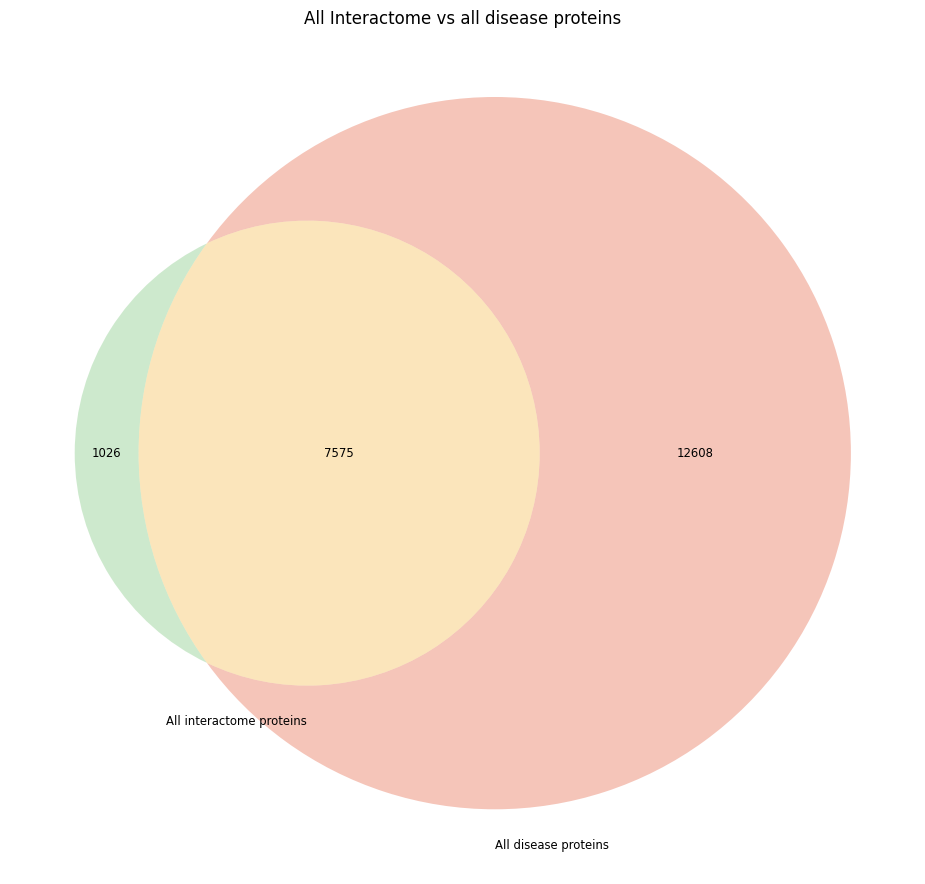

In [18]:
venn_d(set([n for n,_ in pathway_hubgenes]), set([n for n,_ in most_common_nodes_in_all_dis]), 
      "All interactome proteins", "All disease proteins", "All Interactome vs all disease proteins",
          output_filename=os.path.join(figures_dir, "all_interactome_vs_disease_proteins.png"))
plt.show()

##### Explore the different chosen cutoffs for top interactome proteins and most common disease genes

In [19]:
cutoffs1 = [54,53,51,50]
top_x = [100,200,300,400]
prom_genes = []
most_prom_genes_in_int_overlap = []
top_pathway_hubgenes = []

for cutoff, topx in zip(cutoffs1,top_x):
    most_prom = above_cutoff(most_common_nodes_in_all_dis, cutoff)
    most_prom_in_overlap = get_genes_in_overlap(most_prom, interactome_vs_coexp_overlap)
    top_x_pathway_hubgenes = get_top_x_genes_in_overlap(pathway_hubgenes, interactome_vs_coexp_overlap, topx)
    prom_genes.append(most_prom)
    most_prom_genes_in_int_overlap.append(most_prom_in_overlap)
    top_pathway_hubgenes.append(top_x_pathway_hubgenes)
    
for cutoff, prom_genes, prom_genes_in_overlap in zip(cutoffs1,prom_genes,most_prom_genes_in_int_overlap):
    print(f"With a cutoff of >= {cutoff}/{len(network_dict)} networks, there are "
          f"{len(prom_genes)} promiscuous genes, "
          f"\n{len(prom_genes_in_overlap)} of which are genes in the overall interactome "
          f"({len(prom_genes_in_overlap)/len(prom_genes):.2%})\n")

With a cutoff of >= 54/63 networks, there are 317 promiscuous genes, 
106 of which are genes in the overall interactome (33.44%)

With a cutoff of >= 53/63 networks, there are 517 promiscuous genes, 
163 of which are genes in the overall interactome (31.53%)

With a cutoff of >= 51/63 networks, there are 1058 promiscuous genes, 
323 of which are genes in the overall interactome (30.53%)

With a cutoff of >= 50/63 networks, there are 1419 promiscuous genes, 
425 of which are genes in the overall interactome (29.95%)



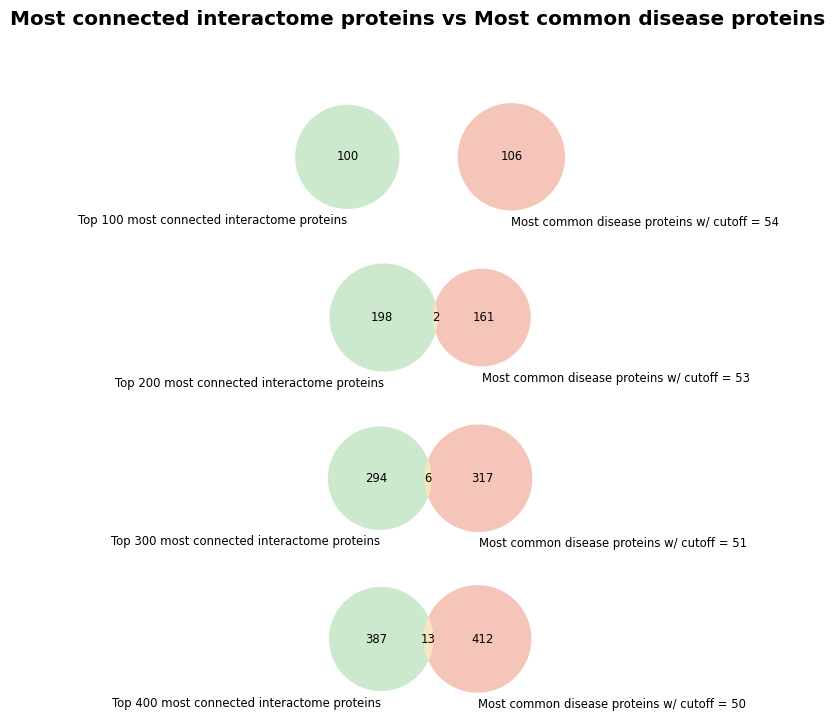

In [20]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Most connected interactome proteins vs Most common disease proteins',weight="bold", size="x-large")
i=1
for pathway_hub, prom_genes_in_overlap, cutoff, topx in zip(top_pathway_hubgenes,most_prom_genes_in_int_overlap,cutoffs1,top_x):
    fig.add_subplot(410+i)
    venn_d(pathway_hub, prom_genes_in_overlap,
           f"Top {topx} most connected interactome proteins", 
           f"Most common disease proteins w/ cutoff = {cutoff}")
    i+=1
plt.savefig(os.path.join(figures_dir, "most_conn_interactome_vs_most_common_disease.png"))
plt.show()

##### Explore the different chosen cutoffs for bottom interactome proteins and least common disease genes

In [21]:
cutoffs2 = [23,25,26,27]
bottom_x = [100,200,300,400]
least_prom_genes = []
least_prom_genes_in_int_overlap = []
bottom_pathway_hubgenes = []

for cutoff, bottomx in zip(cutoffs2,bottom_x):
    least_prom = below_cutoff(least_common_nodes_in_all_dis, cutoff)
    least_prom_in_overlap = get_genes_in_overlap(least_prom, interactome_vs_coexp_overlap)
    bottom_x_pathway_hubgenes = get_top_x_genes_in_overlap(pathway_hubgenes[::-1], interactome_vs_coexp_overlap, bottomx)
    least_prom_genes.append(least_prom)
    least_prom_genes_in_int_overlap.append(least_prom_in_overlap)
    bottom_pathway_hubgenes.append(bottom_x_pathway_hubgenes)

for cutoff, least_prom_genes, least_prom_genes_in_overlap in zip(cutoffs2,least_prom_genes,least_prom_genes_in_int_overlap):
    print(f"With a cutoff of <= {cutoff}/{len(network_dict)} networks, there are "
          f"{len(least_prom_genes)} least promiscuous genes, "
          f"\n{len(least_prom_genes_in_overlap)} of which are genes in the overall interactome "
          f"({len(least_prom_genes_in_overlap)/len(least_prom_genes):.2%})\n")

With a cutoff of <= 23/63 networks, there are 341 least promiscuous genes, 
122 of which are genes in the overall interactome (35.78%)

With a cutoff of <= 25/63 networks, there are 650 least promiscuous genes, 
229 of which are genes in the overall interactome (35.23%)

With a cutoff of <= 26/63 networks, there are 900 least promiscuous genes, 
316 of which are genes in the overall interactome (35.11%)

With a cutoff of <= 27/63 networks, there are 1218 least promiscuous genes, 
437 of which are genes in the overall interactome (35.88%)



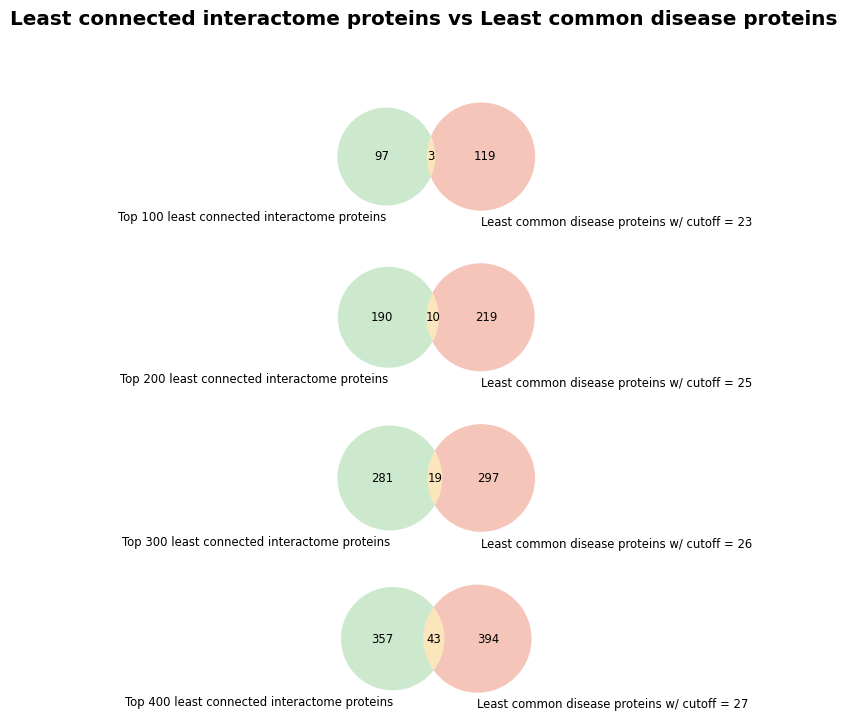

In [22]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Least connected interactome proteins vs Least common disease proteins',weight="bold", size="x-large")
i=1
for pathway_hub, l_prom_genes_in_overlap, cutoff, bottomx in zip(bottom_pathway_hubgenes,least_prom_genes_in_int_overlap,cutoffs2,bottom_x):
    fig.add_subplot(410+i)
    venn_d(pathway_hub, l_prom_genes_in_overlap,
           f"Top {bottomx} least connected interactome proteins", 
           f"Least common disease proteins w/ cutoff = {cutoff}")
    i+=1
plt.savefig(os.path.join(figures_dir, "least_conn_interactome_vs_least_common_disease.png"))
plt.show()

##### Overlap between KEGG and disease proteins

In [23]:
pathways_vs_coexp_overlap = set([n for n,_ in genes_with_most_pathways]).intersection(
    set([n for n,_ in most_common_nodes_in_all_dis]))
print(f"The genes in known pathways and all in the combination of all disease co-expression network have {len(pathways_vs_coexp_overlap)} nodes in common"
     f"\n({len(pathways_vs_coexp_overlap)/len(genes_with_most_pathways):.2%} of all genes in the pathways)"
     f"\n({len(pathways_vs_coexp_overlap)/len(most_common_nodes_in_all_dis):.2%} of all genes in disease co-expression networks)")

The genes in known pathways and all in the combination of all disease co-expression network have 6926 nodes in common
(86.50% of all genes in the pathways)
(34.32% of all genes in disease co-expression networks)


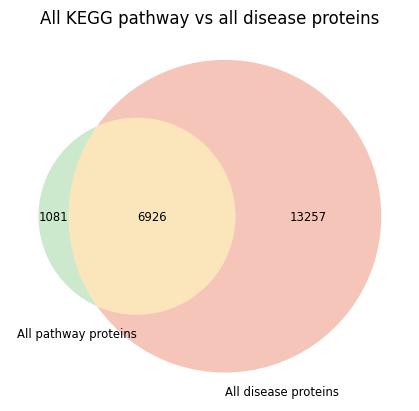

In [24]:
venn_d(set([n for n,_ in genes_with_most_pathways]), set([n for n,_ in most_common_nodes_in_all_dis]), 
      "All pathway proteins", "All disease proteins", "All KEGG pathway vs all disease proteins",
          output_filename=os.path.join(figures_dir, "all_kegg_vs_disease_proteins.png"))
plt.show()

##### Explore the different chosen cutoffs for most common pathway proteins and most common disease proteins

In [25]:
cutoffs3 = [54,52,51,50]
top_x = [100,200,300,400]
prom_genes = []
most_prom_genes_in_path_overlap = []
top_pathway_genes = []

for cutoff, topx in zip(cutoffs3,top_x):
    most_prom = above_cutoff(most_common_nodes_in_all_dis, cutoff)
    most_prom_in_overlap = get_genes_in_overlap(most_prom, pathways_vs_coexp_overlap)
    top_x_pathway_genes = get_top_x_genes_in_overlap(genes_with_most_pathways, pathways_vs_coexp_overlap, topx)
    prom_genes.append(most_prom)
    most_prom_genes_in_path_overlap.append(most_prom_in_overlap)
    top_pathway_genes.append(top_x_pathway_genes)

for cutoff, prom_genes, prom_genes_in_overlap in zip(cutoffs3,prom_genes,most_prom_genes_in_path_overlap):
    print(f"With a cutoff of >= {cutoff}/{len(network_dict)} networks, there are "
          f"{len(prom_genes)} promiscuous genes, "
          f"\n{len(prom_genes_in_overlap)} of which are genes associated with known pathways"
          f"({len(prom_genes_in_overlap)/len(prom_genes):.2%})\n")

With a cutoff of >= 54/63 networks, there are 317 promiscuous genes, 
101 of which are genes associated with known pathways(31.86%)

With a cutoff of >= 52/63 networks, there are 771 promiscuous genes, 
233 of which are genes associated with known pathways(30.22%)

With a cutoff of >= 51/63 networks, there are 1058 promiscuous genes, 
306 of which are genes associated with known pathways(28.92%)

With a cutoff of >= 50/63 networks, there are 1419 promiscuous genes, 
400 of which are genes associated with known pathways(28.19%)



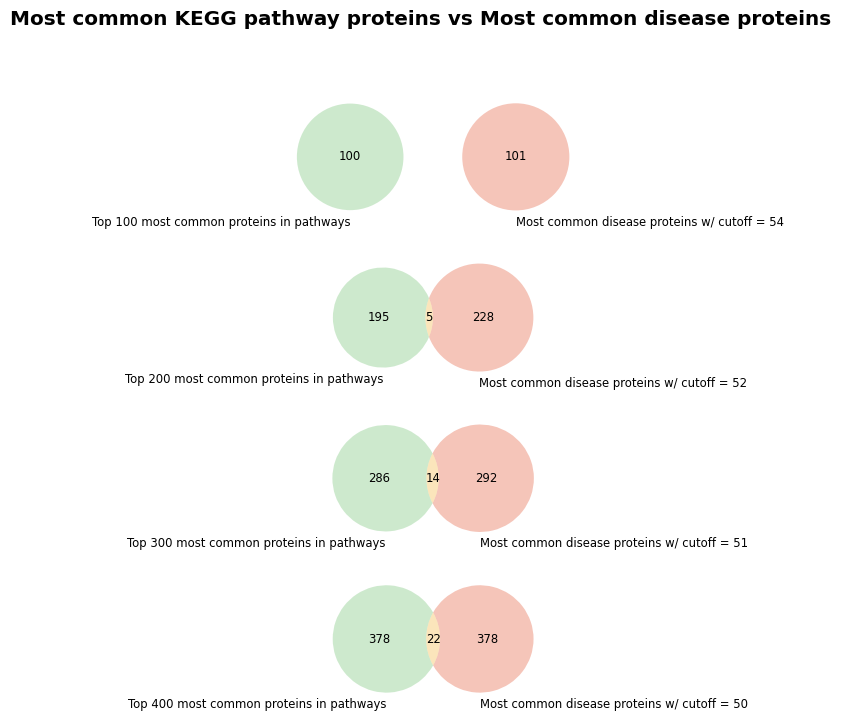

In [26]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Most common KEGG pathway proteins vs Most common disease proteins',weight="bold", size="x-large")
i=1
for pathway_genes, prom_genes_in_overlap, cutoff, topx in zip(top_pathway_genes,most_prom_genes_in_path_overlap,cutoffs3,top_x):
    fig.add_subplot(410+i)
    venn_d(pathway_genes, prom_genes_in_overlap,
           f"Top {topx} most common proteins in pathways", 
           f"Most common disease proteins w/ cutoff = {cutoff}")
    i+=1
    
plt.savefig(os.path.join(figures_dir, "most_common_kegg_prot_vs_most_common_disease.png"))
plt.show()

##### Explore the different chosen cutoffs for the least common pathway proteins and least common disease proteins

In [27]:
cutoffs4 = [23,25,26,27]
bottom_x = [100,200,300,400]
least_prom_genes = []
least_prom_genes_in_path_overlap = []
bottom_pathway_genes = []

for cutoff, bottomx in zip(cutoffs4,bottom_x):
    least_prom = below_cutoff(least_common_nodes_in_all_dis, cutoff)
    least_prom_in_overlap = get_genes_in_overlap(least_prom, pathways_vs_coexp_overlap)
    bottom_x_pathway_genes = get_top_x_genes_in_overlap(genes_with_most_pathways[::-1], pathways_vs_coexp_overlap, bottomx)
    least_prom_genes.append(least_prom)
    least_prom_genes_in_path_overlap.append(least_prom_in_overlap)
    bottom_pathway_genes.append(bottom_x_pathway_genes)


for cutoff, l_prom_genes, l_prom_genes_in_overlap in zip(cutoffs4,least_prom_genes,least_prom_genes_in_path_overlap):
    print(f"With a cutoff of <= {cutoff}/{len(network_dict)} networks, there are "
          f"{len(l_prom_genes)} least promiscuous genes, "
          f"\n{len(l_prom_genes_in_overlap)} of which are associated with known pathways"
          f"({len(l_prom_genes_in_overlap)/len(l_prom_genes):.2%})\n")

With a cutoff of <= 23/63 networks, there are 341 least promiscuous genes, 
110 of which are associated with known pathways(32.26%)

With a cutoff of <= 25/63 networks, there are 650 least promiscuous genes, 
209 of which are associated with known pathways(32.15%)

With a cutoff of <= 26/63 networks, there are 900 least promiscuous genes, 
288 of which are associated with known pathways(32.00%)

With a cutoff of <= 27/63 networks, there are 1218 least promiscuous genes, 
398 of which are associated with known pathways(32.68%)



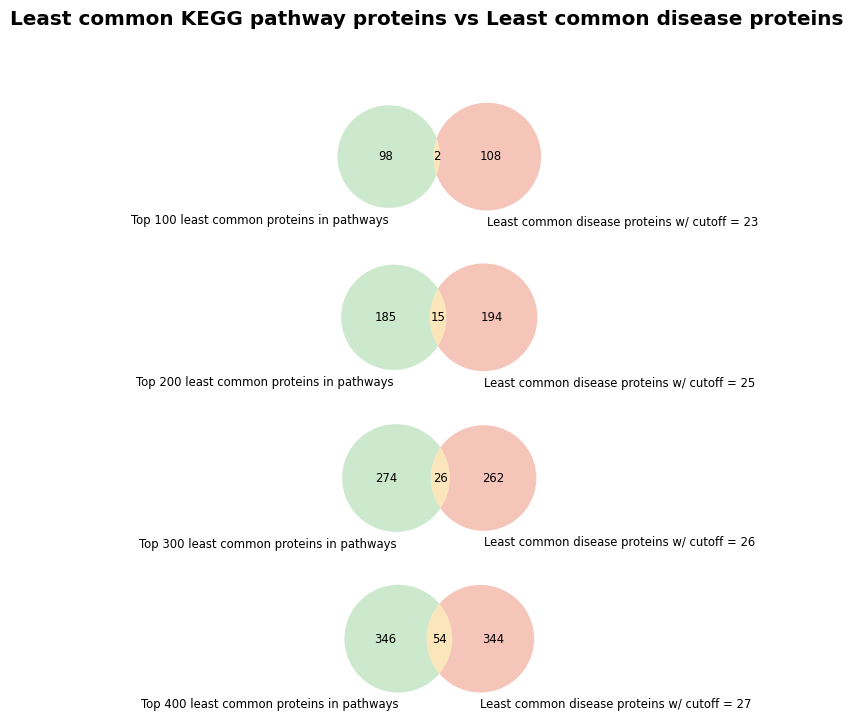

In [28]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Least common KEGG pathway proteins vs Least common disease proteins',weight="bold", size="x-large")
i=1
for pathway_genes, prom_genes_in_overlap, cutoff, topx in zip(bottom_pathway_genes,least_prom_genes_in_path_overlap,cutoffs4,bottom_x):
    fig.add_subplot(410+i)
    venn_d(pathway_genes, prom_genes_in_overlap,
           f"Top {topx} least common proteins in pathways", 
           f"Least common disease proteins w/ cutoff = {cutoff}")
    i+=1
    
plt.savefig(os.path.join(figures_dir, "least_common_kegg_prot_vs_least_common_disease.png"))
plt.show()

## Figure: Merged co-expression network clustering proteins by their association to different disease groups
##### figure was put together externally, here only node associations are made

##### Get list of all nodes

In [29]:
all_nodes = [node for node, _ in most_common_nodes_in_all_dis]

##### For each cluster, identify nodes which are present in each disease within the cluster

In [30]:
node_subset_per_cluster = {}
for category, doids in doids_per_cluster.items():
    if category == "Normal": 
        continue
    node_subset_per_cluster[category] = node_intersection_from_doid_list(doids, network_dict)

##### Subset each node list so that it only contains those that are in every disease of that cluster, without being in the list of another cluster

In [31]:
# find the unique nodes, so far without knowing from which cluster it came from
node_lists = [list(v) for k,v in node_subset_per_cluster.items()]
counter_obj = Counter(chain.from_iterable(node_lists))
nodes_unique_to_a_cluster = [obj for obj, count in counter_obj.items() if count ==1]

# for the unique nodes, find which cluster they were assigned to
unique_node_set_per_cluster = {key : set() for key in node_subset_per_cluster.keys()}
for node in nodes_unique_to_a_cluster:
    for cluster in node_subset_per_cluster.keys():
        if node in node_subset_per_cluster[cluster]:
            unique_node_set_per_cluster[cluster].add(node)
            break

##### How many resulting nodes associated to each cluster?

In [32]:
{k:len(v) for k,v in unique_node_set_per_cluster.items()}

{'Cardiovascular system disease': 2224,
 'Gastrointestinal system disease': 32,
 'Immune system disease': 3,
 'Musculoskeletal system disease': 231,
 'Nervous system disease': 70,
 'Reproductive system disease': 128,
 'Respiratory system disease': 79,
 'Other cancer': 2,
 'Infectious disease': 1510,
 'Cognitive disorder': 714}